In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale, LabelBinarizer
import tensorflow.keras as keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, DepthwiseConv2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import regularizers
from scipy.io import loadmat
from keras.preprocessing.image import ImageDataGenerator

In [63]:
mat = loadmat('svhn_train_32x32.mat')
matest = loadmat('svhn_test_32x32.mat')

In [64]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [65]:
matest['y']

array([[5],
       [2],
       [1],
       ...,
       [7],
       [6],
       [7]], dtype=uint8)

In [66]:
print(mat['X'].shape)
print(matest['X'].shape)
print(mat['y'].shape)
print(matest['y'].shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 1)
(26032, 1)


In [67]:
x_train = np.array(mat['X'])
x_test = np.array(matest['X'])
y_train = mat['y']
y_test = matest['y']

In [68]:
x_train = np.moveaxis(mat['X'], -1, 0)
x_test = np.moveaxis(matest['X'], -1, 0)
print(x_train.shape)
print(x_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


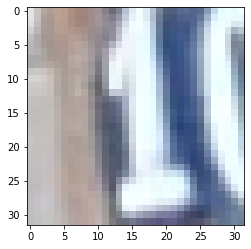

Label:  [1]


In [69]:
plt.imshow(x_train[434])
plt.show()
print('Label: ', y_train[434])

In [70]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [71]:
print(x_train.max())
print(x_test.max())

255.0
255.0


In [72]:
#to normalize data
x_train /= 255.0
x_test /= 225.0

In [73]:
#convert to binary array?
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [74]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
(73257, 10)
(26032, 10)


In [75]:
#let's augment some data 
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [76]:
datagen.fit(x_train)

In [35]:
model = Sequential([
    Conv2D(32, kernel_size = (3, 3), strides = 2, bias_initializer = "zeros", kernel_initializer = 'he_normal', input_shape=(32, 32, 3)),
    Activation('relu'),
    Conv2D(64, kernel_size = (3, 3), strides = 2, kernel_regularizer = regularizers.l2(0.01)),
    Activation('relu'),
    Flatten(),
    #DepthwiseConv2D(kernel_size = (3, 3), strides = (2, 2), depth_multiplier = 3),
    Activation('relu'),
    Dropout(0.5),
    Dense(64, kernel_regularizer = regularizers.l2(0.001)),
    Activation('relu'),
    Dropout(0.4),
    Dense(32, kernel_regularizer = regularizers.l2(0.001)),
    Activation('relu'),
    Dense(10, kernel_regularizer = regularizers.l2(0.001)),
    Activation('softmax'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
activation_8 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
activation_9 (Activation)    (None, 3136)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3136)             

In [36]:
model.compile(optimizer = 'adam',
             loss = "categorical_crossentropy",
             metrics = ['accuracy'])

In [39]:
callbacks = []
callbacks.append(EarlyStopping('val_accuracy', patience = 10, restore_best_weights = True))
callbacks.append(ModelCheckpoint("best-weights.hdf5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, period = 10))

In [40]:
h = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128), epochs = 30,  validation_data = (x_test, y_test), callbacks = callbacks)

Epoch 1/30
573/573 [==============================] - 46s 81ms/step - loss: 1.6607 - accuracy: 0.4951 - val_loss: 1.1618 - val_accuracy: 0.7187
Epoch 2/30
573/573 [==============================] - 40s 69ms/step - loss: 1.5571 - accuracy: 0.5372 - val_loss: 1.0819 - val_accuracy: 0.7534
Epoch 3/30
573/573 [==============================] - 45s 78ms/step - loss: 1.4788 - accuracy: 0.5763 - val_loss: 1.0027 - val_accuracy: 0.7878
Epoch 4/30
573/573 [==============================] - 42s 73ms/step - loss: 1.4107 - accuracy: 0.6084 - val_loss: 0.9504 - val_accuracy: 0.8059
Epoch 5/30
573/573 [==============================] - 39s 68ms/step - loss: 1.3353 - accuracy: 0.6361 - val_loss: 0.9006 - val_accuracy: 0.8156
Epoch 6/30
573/573 [==============================] - 38s 67ms/step - loss: 1.2893 - accuracy: 0.6555 - val_loss: 0.8826 - val_accuracy: 0.8174
Epoch 7/30
573/573 [==============================] - 39s 68ms/step - loss: 1.2470 - accuracy: 0.6726 - val_loss: 0.8990 - val_accuracy:

In [80]:
print(h.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [81]:
accuracy = model.evaluate(x_test, y_test)
print(f"Validation Accuracy UNTRAINED: {h.history['val_accuracy'][-1]:.02f}")
print(f"Final Loss on Testing Data UNTRAINED: {accuracy[0]:02f}")
print(f"Final Untrained Test ACCURACY: {accuracy[1]:02f}")

26032/26032 [==============================] - 3s 105us/step
Validation Accuracy UNTRAINED: 0.85
Final Loss on Testing Data UNTRAINED: 0.739892
Final Untrained Test ACCURACY: 0.850530


In [82]:
model.load_weights("best-weights.hdf5")
accuracy = model.evaluate(x_test, y_test)
print(f"Validation Accuracy UNTRAINED: {h.history['val_accuracy'][-1]:.02f}")
print(f"Final Loss on Testing Data TRAINED: {accuracy[0]:02f}")
print(f"Final Trained Test ACCURACY: {accuracy[1]:02f}")

26032/26032 [==============================] - 2s 86us/step
Validation Accuracy UNTRAINED: 0.85
Final Loss on Testing Data TRAINED: 0.739892
Final Trained Test ACCURACY: 0.850530


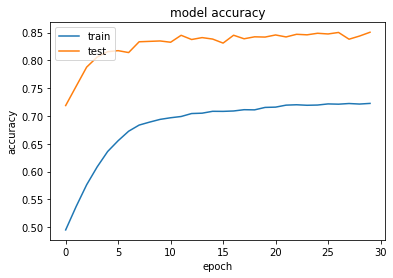

In [83]:
##ACCURACY GRAPH
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

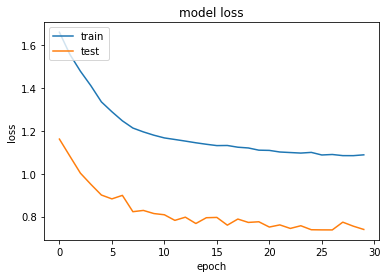

In [84]:
##LOSS GRAPH
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

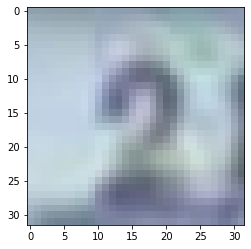

In [88]:
plt.imshow(x_test[1])

In [103]:
def odd_or_even(pred):
    if (pred%2 == 0):
        return "even"
    else:
        return "odd"

In [104]:
x_test[1].shape

(32, 32, 3)

In [105]:
even_odd = {}
for index in range(26032):
    pred = model.predict(x_test[index].reshape(1, 32, 32, 3))
    even_odd[index] = [pred.argmax(), odd_or_even(pred.argmax())]

In [106]:
even_odd

{0: [4, 'even'],
 1: [1, 'odd'],
 2: [0, 'even'],
 3: [9, 'odd'],
 4: [6, 'even'],
 5: [9, 'odd'],
 6: [8, 'even'],
 7: [0, 'even'],
 8: [0, 'even'],
 9: [7, 'odd'],
 10: [2, 'even'],
 11: [4, 'even'],
 12: [4, 'even'],
 13: [0, 'even'],
 14: [3, 'odd'],
 15: [3, 'odd'],
 16: [0, 'even'],
 17: [9, 'odd'],
 18: [2, 'even'],
 19: [3, 'odd'],
 20: [1, 'odd'],
 21: [9, 'odd'],
 22: [0, 'even'],
 23: [8, 'even'],
 24: [1, 'odd'],
 25: [4, 'even'],
 26: [3, 'odd'],
 27: [0, 'even'],
 28: [3, 'odd'],
 29: [1, 'odd'],
 30: [8, 'even'],
 31: [2, 'even'],
 32: [4, 'even'],
 33: [5, 'odd'],
 34: [9, 'odd'],
 35: [0, 'even'],
 36: [4, 'even'],
 37: [0, 'even'],
 38: [1, 'odd'],
 39: [1, 'odd'],
 40: [8, 'even'],
 41: [0, 'even'],
 42: [5, 'odd'],
 43: [3, 'odd'],
 44: [8, 'even'],
 45: [7, 'odd'],
 46: [0, 'even'],
 47: [1, 'odd'],
 48: [9, 'odd'],
 49: [5, 'odd'],
 50: [8, 'even'],
 51: [0, 'even'],
 52: [4, 'even'],
 53: [0, 'even'],
 54: [8, 'even'],
 55: [5, 'odd'],
 56: [5, 'odd'],
 57: [4, '